Oracle updates are expensive. This notebook focuses on coming up with an optimal oracle update strategy that minimises gas costs but is reasonable enough: not for too long such that oracle price deviates from spot too much consistently.

In [1]:
import os
import sys

sys.path.append("../utils")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

from cvx_synth_asset_oracle import ConvexSynthAssetOracleLite

In [2]:
save_file_dir = "../data/cvxcrv_pool_data.csv"
pool_data = pd.DataFrame()
if os.path.exists(save_file_dir):
    pool_data = pd.read_csv(save_file_dir)
pool_data.set_index('block', inplace=True)
pool_data

,crvusd_price,ethusd_price,cvxcrv_crv_1,cvxcrv_crv_10,cvxcrv_crv_100,cvxcrv_crv_1000,cvxcrv_crv_10000,cvxcrv_pool_balance,crv_pool_balance
block,,,,,,,,,
13056869,2.070921,3066.626358,0.996924,9.132532,10.082833,10.084830,10.084850,9.900095e+00,1.010000e+01
13056984,2.052405,3041.060346,0.994729,9.947286,99.472498,994.688360,9943.196023,5.520935e+05,4.564644e+05
13058684,2.121912,3175.374060,0.996586,9.965855,99.658231,996.550167,9962.276366,5.812792e+05,5.272852e+05
13058701,2.121912,3175.374060,0.995442,9.954414,99.543810,995.405334,9950.759193,5.971679e+05,5.114479e+05
13058709,2.121912,3175.374060,0.991493,9.914924,99.148867,991.451563,9910.763473,6.485631e+05,4.603481e+05
...,...,...,...,...,...,...,...,...,...
14061352,3.071517,2522.084130,0.950490,9.504899,95.048955,950.485643,9504.465075,4.081266e+07,1.090499e+07
14061355,3.071517,2522.084130,0.950430,9.504301,95.042975,950.425835,9503.866384,4.081954e+07,1.089845e+07
14061360,3.071517,2522.084130,0.950403,9.504030,95.040257,950.398647,9503.594233,4.082266e+07,1.089547e+07


In [3]:
save_file_dir = "../data/chainlink_oracle_outputs.csv"
chainlink_data = pd.DataFrame()
if os.path.exists(save_file_dir):
    chainlink_data = pd.read_csv(save_file_dir)
chainlink_data.set_index('block', inplace = True)
chainlink_data

,crvusd,ethusd
block,,
13056724,2.070921,3066.626358
13056725,2.070921,3066.626358
13056726,2.070921,3066.626358
13056727,2.070921,3066.626358
13056728,2.070921,3066.626358
...,...,...
14063831,2.868000,2415.346183
14063832,2.868000,2415.346183
14063833,2.868000,2415.346183


Update Swap Rate every N(=1000) blocks or if price cvxCRV changes by 2%:

In [4]:
oracle_update_block_steps = 2000
spot_price_change_threshold = 0.02  # fraction
start_block = chainlink_data.index.min()
end_block = chainlink_data.index.max()
oracle_update_blocks = list(range(start_block, end_block + oracle_update_block_steps, oracle_update_block_steps))
num_gas_per_call = 83624

In [5]:
chainlink_data.loc[pool_data.index, 'swap_rate'] = pool_data.cvxcrv_crv_1
simulation_data = chainlink_data.ffill().dropna()
simulation_data

,crvusd,ethusd,swap_rate
block,,,
13056869,2.070921,3066.626358,0.996924
13056870,2.070921,3066.626358,0.996924
13056871,2.070921,3066.626358,0.996924
13056872,2.070921,3066.626358,0.996924
13056873,2.070921,3066.626358,0.996924
...,...,...,...
14063831,2.868000,2415.346183,0.950466
14063832,2.868000,2415.346183,0.950466
14063833,2.868000,2415.346183,0.950466


In [6]:
oracle_price = np.zeros((simulation_data.shape[0],))
optimised_oracle_price = np.zeros((simulation_data.shape[0],))
oracle_ema_rate = np.zeros((simulation_data.shape[0],))
optimised_oracle_ema_rate = np.zeros((simulation_data.shape[0],))

spot_price = np.zeros((simulation_data.shape[0],))
update_due_to_price_change = np.full((simulation_data.shape[0],), False)
update_due_to_schedule = np.full((simulation_data.shape[0],), False)

In [11]:
update_ema_rate = True
last_spot_price = 0
spot_price_change = 0

cvxcrv_oracle_optimised = ConvexSynthAssetOracleLite()
cvxcrv_oracle = ConvexSynthAssetOracleLite()

c = 0
for idx, row in simulation_data.iterrows():

    block = idx
    crvusd_chainlink_price = row.crvusd
    swap_rate = row.swap_rate
    scheduled_update = False
    volatility_update = False

    # get oracle price before ema rate upgrade:
    current_cvxcrv_spot_price = swap_rate * crvusd_chainlink_price
    if last_spot_price > 0:
        spot_price_change = abs(last_spot_price - current_cvxcrv_spot_price) / last_spot_price

    # ------------ S T A R T  O R A C L E  U P D A T E  L O G I C ------------ #

    # update if block falls under regular oracle update blocks:
    if block in oracle_update_blocks:
        # print(f"Scheduled oracle update at block {idx}.")
        update_ema_rate = True
        scheduled_update = True

    # update if cvxcrv spot price changes by 2%:
    if spot_price_change > spot_price_change_threshold:
        # print(f"Spot price change exceeds max at block {idx}. Change: {spot_price_change * 1E2}%.")
        update_ema_rate = True
        volatility_update = True

    # ------------ E N D  O R A C L E  U P D A T E  L O G I C ------------ #

    # update optimised cvxcrv oracle:
    if update_ema_rate:
        cvxcrv_oracle_optimised.update_ema_rate(_latest_swap_rate=swap_rate * 1e18)
        # print(f"Updating ema rate for optimised oracle (block {idx}): {cvxcrv_oracle_optimised.ema_swap_rate * 1e-18}")
    cvxcrv_oracle.update_ema_rate(_latest_swap_rate=swap_rate * 1e18)  # this gets updated regardless as we want to optimise against this.

    # calculate oracle price after ema rate update:
    cvxCRV_oracle_price = cvxcrv_oracle.latestAnswer(int(crvusd_chainlink_price * 1E8)) * 1e-18
    cvxCRV_optimised_oracle_price = cvxcrv_oracle_optimised.latestAnswer(int(crvusd_chainlink_price * 1E8)) * 1e-18

    oracle_price[c] = cvxCRV_oracle_price
    optimised_oracle_price[c] = cvxCRV_optimised_oracle_price
    oracle_ema_rate[c] = cvxcrv_oracle.ema_swap_rate * 1e-18
    optimised_oracle_ema_rate[c] = cvxcrv_oracle_optimised.ema_swap_rate * 1e-18
    spot_price[c] = current_cvxcrv_spot_price
    update_due_to_price_change[c] = volatility_update
    update_due_to_schedule[c] = scheduled_update

    # reset update bool
    update_ema_rate = False
    last_spot_price = current_cvxcrv_spot_price
    c += 1

simulation_data['oracle_price'] = oracle_price
simulation_data['oracle_ema_rate'] = oracle_ema_rate
simulation_data['spot_price'] = spot_price
simulation_data['update_due_to_price_change'] = update_due_to_price_change
simulation_data['update_due_to_schedule'] = update_due_to_schedule
simulation_data['optimised_oracle_price'] = optimised_oracle_price
simulation_data['optimised_oracle_ema_rate'] = optimised_oracle_ema_rate

simulation_data

,crvusd,ethusd,swap_rate,oracle_price,oracle_ema_rate,spot_price,update_due_to_price_change,update_due_to_schedule,optimised_cvxcrv_oracle_price,optimised_oracle_ema_rate,optimised_oracle_price
block,,,,,,,,,,,
13056869,2.070921,3066.626358,0.996924,2.064550,0.996924,2.064550,False,False,2.064550,0.996924,2.064550
13056870,2.070921,3066.626358,0.996924,2.064550,0.996924,2.064550,False,False,2.064550,0.996924,2.064550
13056871,2.070921,3066.626358,0.996924,2.064550,0.996924,2.064550,False,False,2.064550,0.996924,2.064550
13056872,2.070921,3066.626358,0.996924,2.064550,0.996924,2.064550,False,False,2.064550,0.996924,2.064550
13056873,2.070921,3066.626358,0.996924,2.064550,0.996924,2.064550,False,False,2.064550,0.996924,2.064550
...,...,...,...,...,...,...,...,...,...,...,...
14063831,2.868000,2415.346183,0.950466,2.809523,0.979610,2.725936,False,False,2.807347,0.978852,2.807347
14063832,2.868000,2415.346183,0.950466,2.809523,0.979610,2.725936,False,False,2.807347,0.978852,2.807347
14063833,2.868000,2415.346183,0.950466,2.809522,0.979610,2.725936,False,False,2.807347,0.978852,2.807347


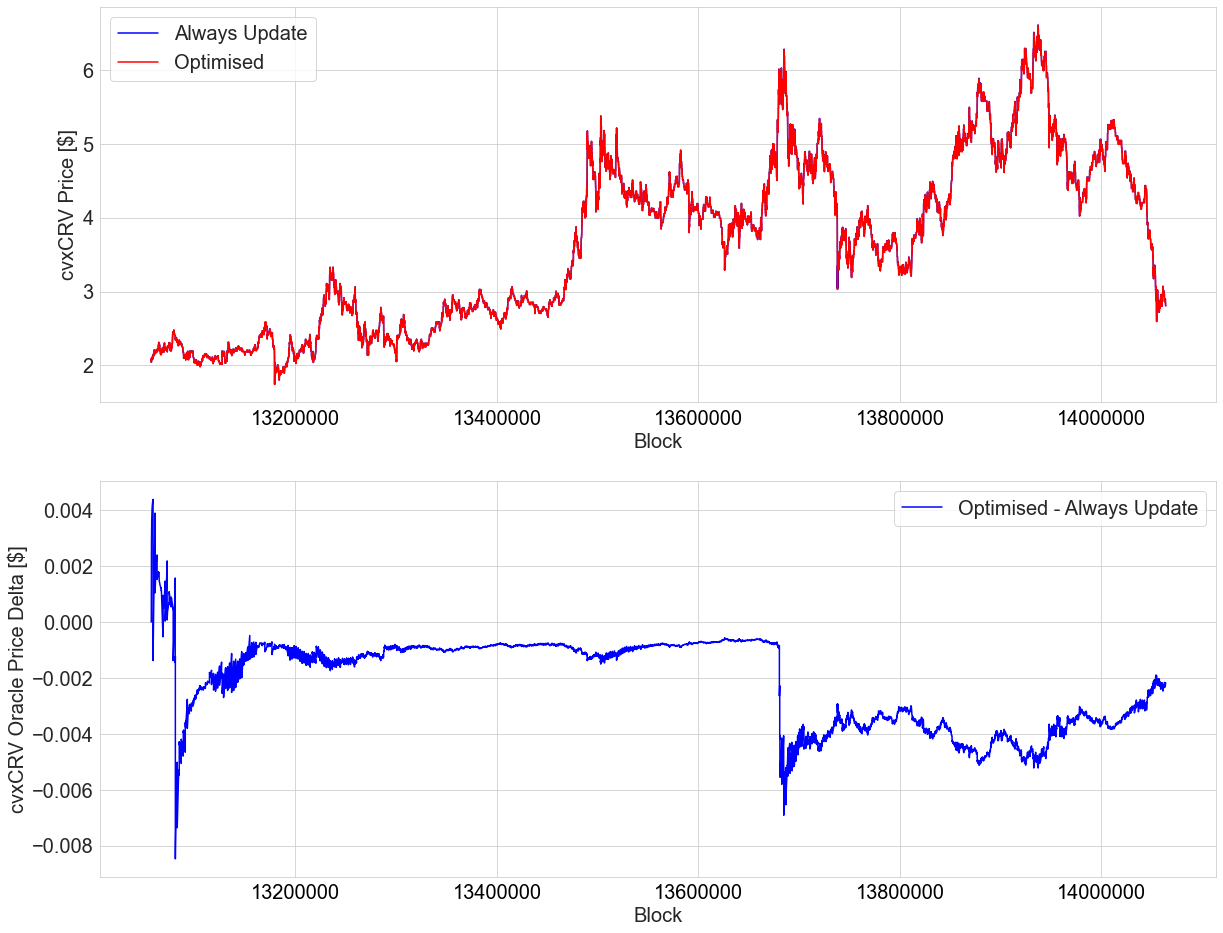

In [12]:
fig, axes = plt.subplots(2, 1, figsize=(20, 16))

ax = axes[0]
ax.plot(
    simulation_data.index,
    simulation_data.oracle_price,
    color='blue',
    label='Always Update'
)
ax.plot(
    simulation_data.index,
    simulation_data.optimised_oracle_price,
    color='red',
    label='Optimised'
)

ax.set_xlabel("Block", fontsize=20)
ax.set_ylabel("cvxCRV Price [$]", fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.tick_params(axis='x', which='major', colors='black')
ax.legend(fontsize=20)
ax.xaxis.get_major_formatter().set_scientific(False)
ax.xaxis.get_major_formatter().set_useOffset(False)

ax = axes[1]
ax.plot(
    simulation_data.index,
    simulation_data.optimised_oracle_price - simulation_data.oracle_price,
    color='blue',
    label='Optimised - Always Update'
)

ax.set_xlabel("Block", fontsize=20)
ax.set_ylabel("cvxCRV Oracle Price Delta [$]", fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.tick_params(axis='x', which='major', colors='black')
ax.legend(fontsize=20)
ax.xaxis.get_major_formatter().set_scientific(False)
ax.xaxis.get_major_formatter().set_useOffset(False)

In [15]:
num_gas_per_call * (update_due_to_schedule.sum() + update_due_to_price_change.sum())

44237096